In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import json
import joblib
import os

In [2]:
# 1. LOAD AND PREPROCESS
df = pd.read_csv("power_data.csv")

In [3]:
le_sensor = LabelEncoder()
le_loc = LabelEncoder()

df["Sensor_ID"] = le_sensor.fit_transform(df["Sensor_ID"])
df["Location"] = le_loc.fit_transform(df["Location"])

In [4]:
# --- NOVELTY 1: Physics-Informed Feature Engineering ---
# We calculate how much the reported Power deviates from the theoretical P = V*I*PF
# This "Physics_Deviation" becomes a critical feature for the model.
theoretical_power = (df["Voltage (V)"] * df["Current (A)"] * df["Power_Factor"]) / 1000
df["Physics_Deviation"] = abs(df["Power (kW)"] - theoretical_power)
# -------------------------------------------------------

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

zones = df["Location"].unique()

In [5]:
# Updated feature list including the Physics feature
feature_cols = ["Voltage (V)", "Current (A)", "Power (kW)", "Frequency (Hz)", 
                "Power_Factor", "Sensor_ID", "Physics_Deviation"]

# 2. HYBRID TRAINING LOOP
zone_models = {}
zone_scalers = {}
zone_iso_forests = {} # Store unsupervised models

In [6]:
print("Training Hybrid Physics-Informed Models...")

for z in zones:
    zone_train = train_df[train_df["Location"] == z]
    
    X = zone_train[feature_cols]
    y = zone_train["Anomaly_Label"]
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # --- NOVELTY 2: Hybrid Unsupervised Layer ---
    # Train Isolation Forest to detect statistical outliers
    iso = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
    iso.fit(X_scaled)
    
    # Generate Anomaly Score (-score because lower is more anomalous)
    iso_scores = -iso.decision_function(X_scaled)
    
    # Stack the Score as a new feature for the Supervised Model
    X_hybrid = np.column_stack((X_scaled, iso_scores))
    # --------------------------------------------
    
    model = RandomForestClassifier(n_estimators=200, class_weight={0:1,1:4}, random_state=42)
    model.fit(X_hybrid, y)
    
    zone_models[z] = model
    zone_scalers[z] = scaler
    zone_iso_forests[z] = iso

Training Hybrid Physics-Informed Models...


In [7]:
# 3. HYBRID PREDICTION
def hybrid_predict(row):
    loc = row["Location"]
    
    # Extract features (ensure order matches training)
    feats = pd.DataFrame([row[feature_cols]], columns=feature_cols)
    
    # Scale
    X_scaled = zone_scalers[loc].transform(feats)
    
    # Get Unsupervised Score
    iso_score = -zone_iso_forests[loc].decision_function(X_scaled)
    
    # Stack
    X_hybrid = np.column_stack((X_scaled, iso_score))
    
    # Predict
    return zone_models[loc].predict(X_hybrid)[0]

In [8]:
test_df["Predicted_Anomaly"] = test_df.apply(hybrid_predict, axis=1)

In [9]:
# 4. CLASSIFICATION METRICS
y_true = test_df["Anomaly_Label"]
y_pred = test_df["Predicted_Anomaly"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Accuracy: 0.9621647509578544

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1750
           1       0.96      0.80      0.87       338

    accuracy                           0.96      2088
   macro avg       0.96      0.90      0.93      2088
weighted avg       0.96      0.96      0.96      2088


Confusion Matrix:
[[1738   12]
 [  67  271]]


In [10]:
# 5. REGRESSION MODEL (DIGITAL TWIN VERIFICATION)
# Keeping your original regression logic exactly as is
reg_features = ["Sensor_ID", "Location", "Frequency (Hz)", "Power_Factor"]
target_cols = ["Voltage (V)", "Current (A)", "Power (kW)"]

X_reg = train_df[reg_features]
y_reg = train_df[target_cols]

reg_scaler = MinMaxScaler()
X_reg_scaled = reg_scaler.fit_transform(X_reg)

reg_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42))
reg_model.fit(X_reg_scaled, y_reg)

X_test = test_df[reg_features]
X_test_scaled = reg_scaler.transform(X_test)

In [11]:
predicted_values = reg_model.predict(X_test_scaled)
test_df[["Pred_Voltage", "Pred_Current", "Pred_Power"]] = predicted_values

In [12]:
# 6. COMPARISON TABLE
comparison_table = test_df[[
    "Sensor_ID","Location",
    "Voltage (V)","Pred_Voltage",
    "Current (A)","Pred_Current",
    "Power (kW)","Pred_Power",
    "Anomaly_Label","Predicted_Anomaly"
]]

print("\nComparison Table Preview:")
print(comparison_table.head(10))


Comparison Table Preview:
       Sensor_ID  Location  Voltage (V)  Pred_Voltage  Current (A)  \
5646           3         3   235.852991    232.073283     3.545476   
3107           4         1   223.862789    225.772824     6.657980   
7431           4         1   190.879314    232.805281     4.475402   
10019          4         2   233.450414    228.504814     7.202326   
9066           3         3   227.229740    231.301124     4.545299   
5556           1         2   235.121133    229.281172     4.447990   
3290           2         1   225.638931    227.339941     5.095651   
3412           0         0   238.411750    231.039762     3.164566   
970            2         3   171.919516    232.221261     5.022143   
3946           3         4   226.217993    229.250672     5.579545   

       Pred_Current  Power (kW)  Pred_Power  Anomaly_Label  Predicted_Anomaly  
5646       4.645165    0.836211    1.106074              0                  0  
3107       4.959247    1.490474    1.09420

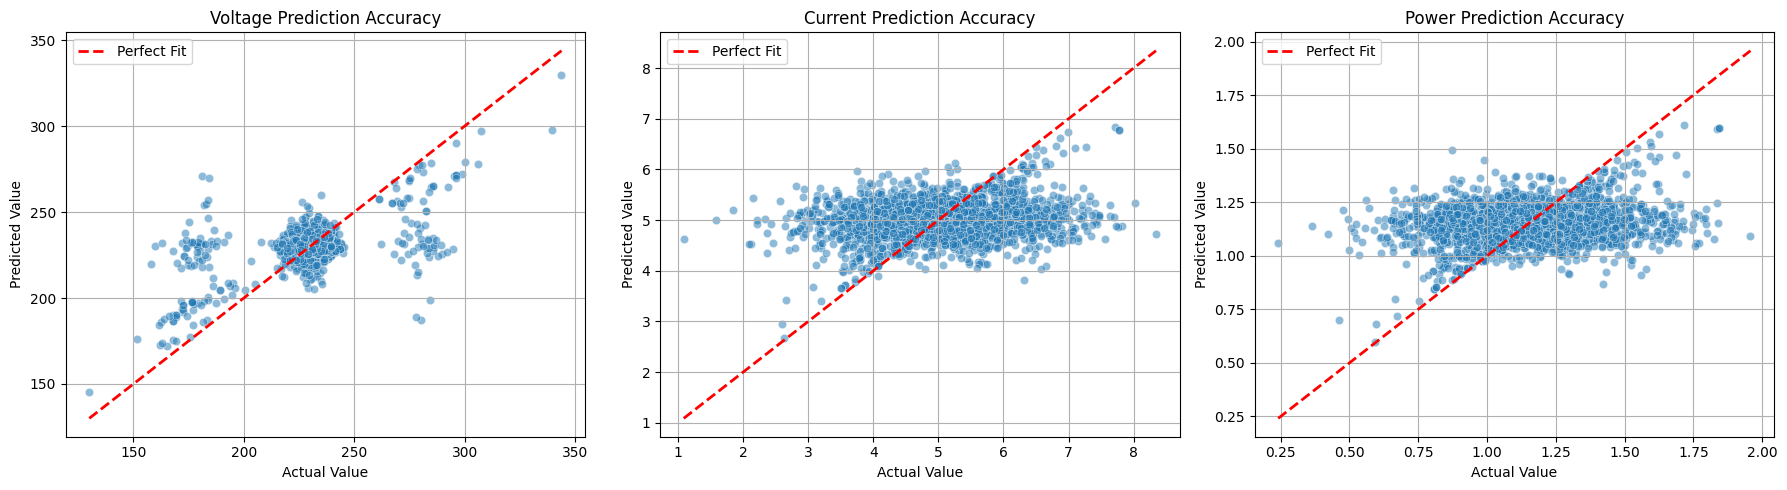

In [25]:
# 7. SCATTER PLOTS (Regression Accuracy)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = [
    ("Voltage (V)", "Pred_Voltage"),
    ("Current (A)", "Pred_Current"),
    ("Power (kW)",  "Pred_Power")
]

for i, (col_actual, col_pred) in enumerate(metrics):
    ax = axes[i]
    sns.scatterplot(
        x=comparison_table[col_actual],
        y=comparison_table[col_pred],
        ax=ax,
        alpha=0.5
    )
    
    min_val = min(comparison_table[col_actual].min(), comparison_table[col_pred].min())
    max_val = max(comparison_table[col_actual].max(), comparison_table[col_pred].max())
    
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
    
    ax.set_title(f"{col_actual.split()[0]} Prediction Accuracy")
    ax.set_xlabel("Actual Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 8. ANOMALY DASHBOARD
zone = zones[0]
zone_df = test_df[test_df["Location"] == zone].sort_index()

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

def plot_zone_metric(ax, actual, predicted, anomalies, title, ylabel):
    ax.plot(actual.index, actual, label="Actual", color='tab:blue', alpha=0.7)
    ax.plot(predicted.index, predicted, label="Predicted", color='orange', linestyle='--')
    
    ax.scatter(anomalies.index, actual.loc[anomalies.index], 
               color='red', label='Anomaly Detected', marker='x', s=100, zorder=5)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3)

anoms = zone_df[zone_df["Predicted_Anomaly"] == 1]

plot_zone_metric(axes[0], zone_df["Voltage (V)"], zone_df["Pred_Voltage"], anoms, 
                 f"Zone {zone}: Voltage Anomalies", "Voltage (V)")

plot_zone_metric(axes[1], zone_df["Current (A)"], zone_df["Pred_Current"], anoms, 
                 f"Zone {zone}: Current Anomalies", "Current (A)")

plot_zone_metric(axes[2], zone_df["Power (kW)"], zone_df["Pred_Power"], anoms, 
                 f"Zone {zone}: Power Anomalies", "Power (kW)")

plt.xlabel("Time Step (Index)")
plt.tight_layout()
plt.show()

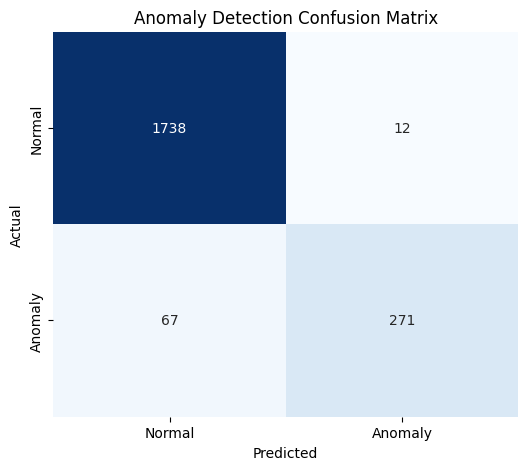

In [23]:
# 9. CONFUSION MATRIX HEATMAP
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Anomaly Detection Confusion Matrix')
plt.show()

In [16]:
# 10. FEATURE IMPORTANCE (Updated for Hybrid Model)
# Note: The model now has one extra feature from the stack: "Anomaly_Score"
example_model = zone_models[zones[0]]
importances = example_model.feature_importances_
indices = np.argsort(importances)[::-1]

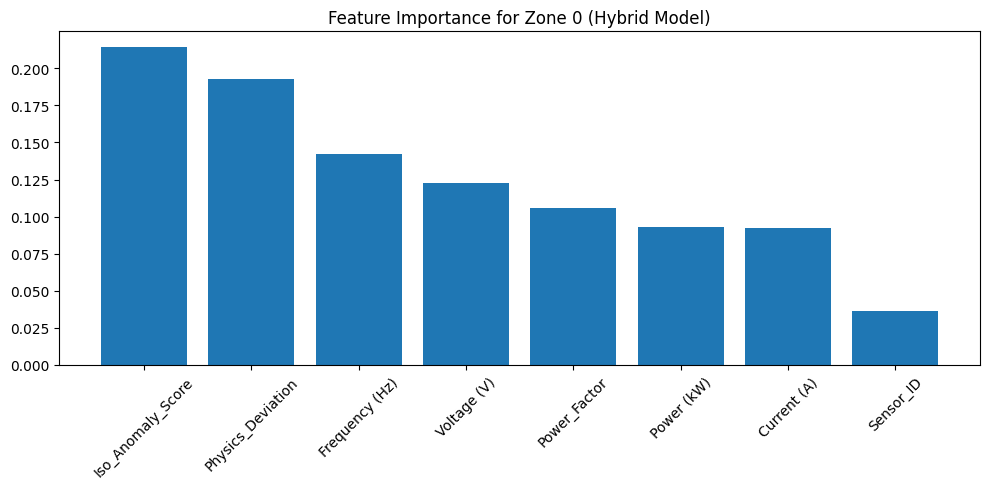

In [24]:
# We must account for the extra "Anomaly_Score" feature in the labels
hybrid_feature_names = feature_cols + ["Iso_Anomaly_Score"]

plt.figure(figsize=(10, 5))
plt.title(f"Feature Importance for Zone {zones[0]} (Hybrid Model)")
plt.bar(range(len(hybrid_feature_names)), importances[indices], align="center")
plt.xticks(range(len(hybrid_feature_names)), [hybrid_feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# 11. ALERTS & EXPORTS
print("\nLive Alerts:")
for _, row in comparison_table[comparison_table["Predicted_Anomaly"] == 1].head(10).iterrows():
    print(f"ALERT: Sensor {row['Sensor_ID']} in Zone {row['Location']} is ANOMALOUS")

sensor_network = test_df[[
    "Sensor_ID", "Location", "Voltage (V)", "Current (A)", 
    "Power (kW)", "Predicted_Anomaly"
]]
sensor_network.to_csv("sensor_network.csv", index=False)

alerts = []
for _, row in test_df[test_df["Predicted_Anomaly"] == 1 ].iterrows():
    alerts.append({
        "sensor": int(row["Sensor_ID"]),
        "zone": int(row["Location"]),
        "voltage": float(row["Voltage (V)"]),
        "current": float(row["Current (A)"]),
        "power": float(row["Power (kW)"]),
        "timestamp": str(row["Timestamp"]) if "Timestamp" in row else "N/A",
        "alert": "ANOMALY DETECTED"
    })

alert_json = json.dumps(alerts, indent=2)
with open("live_alerts.json", "w") as f:
    f.write(alert_json)


Live Alerts:
ALERT: Sensor 4.0 in Zone 1.0 is ANOMALOUS
ALERT: Sensor 0.0 in Zone 0.0 is ANOMALOUS
ALERT: Sensor 4.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 1.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 4.0 in Zone 2.0 is ANOMALOUS
ALERT: Sensor 3.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 1.0 in Zone 0.0 is ANOMALOUS
ALERT: Sensor 2.0 in Zone 4.0 is ANOMALOUS
ALERT: Sensor 0.0 in Zone 2.0 is ANOMALOUS
ALERT: Sensor 4.0 in Zone 2.0 is ANOMALOUS


In [19]:
# 12. SAVE MODELS
os.makedirs('models/physical', exist_ok=True)
joblib.dump(zone_models, 'models/physical/zone_models.joblib')
joblib.dump(zone_scalers, 'models/physical/zone_scalers.joblib')
joblib.dump(zone_iso_forests, 'models/physical/zone_iso_forests.joblib')

['models/physical/zone_iso_forests.joblib']